In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmp9ge57f3n/pubring.gpg' created
gpg: /tmp/tmp9ge57f3n/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [3]:
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

!pip install keras

In [4]:
###############################################################################
# Libraries import
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import cv2

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
from keras import backend as K
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
K.set_image_dim_ordering('th')
from keras.preprocessing.image import ImageDataGenerator

###############################################################################


Using TensorFlow backend.


In [55]:
# Give a name to id the data used in this training
# use the name of validation driver

# These are the validation divisions created from driver ids:

valid_ids= [['p066', 'p021', 'p024'],
 ['p026', 'p072', 'p015'],
 ['p052', 'p061', 'p042', 'p081'],
 ['p016', 'p041', 'p050'],
 ['p047', 'p064', 'p035'],
 ['p049', 'p002', 'p012', 'p039'],
 ['p056', 'p051', 'p022'],
 ['p075', 'p014', 'p045']]


# Select the validation id group to use for this particular training

i=7
print(valid_ids[i])


# generate file name to identify the valid ids group used

if len(valid_ids[i]) == 3:
  train_data_filename = str(valid_ids[i][0] + "_" + valid_ids[i][1] + "_" +
                         valid_ids[i][2] + "_1_96_128")
else:
  train_data_filename = str(valid_ids[i][0] + "_" + valid_ids[i][1] + "_" +
                          valid_ids[i][2] + "_" + valid_ids[i][3] + "_1_96_128")
    

print(train_data_filename)

# generate location address for train data
train_file_address =  str("drive/Colab_Notebooks/x_train_" + train_data_filename + ".pk1")
train_file_address2 =  str("drive/Colab_Notebooks/y_train_xy_valid_" + train_data_filename + ".pk1")

print(train_file_address)
print(train_file_address2)


# Create a validation prediction file for dashboard and other visualization 
# Read the original drivers_img_list for validation drivers only
# Short by validation driver in this particular dataset


# Read the full drivers list
train_driver_list = pd.read_csv('drive/Colab_Notebooks/Data/driver_imgs_list.csv')

# filter out only drivers from the validation set
valid_df =train_driver_list.loc[train_driver_list['subject'].isin(valid_ids[i])]



['p075', 'p014', 'p045']
p075_p014_p045_1_96_128
drive/Colab_Notebooks/x_train_p075_p014_p045_1_96_128.pk1
drive/Colab_Notebooks/y_train_xy_valid_p075_p014_p045_1_96_128.pk1


In [0]:
# Import and read data fromm pickle sets
import pickle
with open (train_file_address, 'rb') as f:
    x_train = pickle.load(f)
       
with open (train_file_address2, 'rb') as f:
    y_train = pickle.load(f)
    x_valid = pickle.load(f)
    y_valid = pickle.load(f)

In [57]:
#  Verify data shape
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)


(20010, 1, 96, 128)
(20010, 10)
(2414, 1, 96, 128)
(2414, 10)


In [58]:
# Define some image and class parameters
# color type: 1 = grey, 3 = rgb
color_type = 1
img_rows, img_cols = 96, 128
nb_classes = 10  # 2 for "imgs_sub2"; 10 for others


input_dim = img_rows * img_cols

print(input_dim)
   
##############################################################################

12288


In [0]:
# reshape images for the Logistic Regression

X_train = x_train.reshape(len(x_train), input_dim) 
X_valid = x_valid.reshape(len(x_valid), input_dim) 
X_train = X_train.astype('float32') 
X_valid = X_valid.astype('float32') 


In [0]:
# Set model batch size and epoch parameters.
batch_size =100
nb_epoch =100


In [61]:
# create a Logistic model with keras

from keras.optimizers import SGD, Adam, Adadelta, Adamax
from keras.regularizers import L1L2

# Key to select if using as-is data(transposed, resize, grey scale) Or
# if using augmented data.  (0 for as-is, 1 for augmented)

augm_data = 0

print(batch_size)


# read saved model, if any
model_from_cache = 0
if model_from_cache == 1:
    model = read_model()
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')
else:
    output_dim = nb_classes = 10 
    model = Sequential() 
    model.add(Dense(output_dim, input_dim=input_dim, 
                    activation='softmax')) 
    
    adadel = Adadelta(lr=0.59, rho=0.95, epsilon=None, decay=0.0)
    
    sgd = SGD(lr=0.0002, momentum=0.75, decay=0.000001, nesterov=True)
    
    
    # compile and train model
    model.compile(loss='categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])

    if augm_data ==  0:
        # For Non-augmented data
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,
                  verbose=1, validation_data=(X_valid, y_valid))
    else:
    # for augmented data
        history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                            epochs=nb_epoch,
                            verbose=1, steps_per_epoch=len(x_train)/batch_size, 
                            validation_data=(X_valid, y_valid))

model.summary()  # get model summary
 
###############################################################################





100
Train on 20010 samples, validate on 2414 samples
Epoch 1/100
20010/20010 [==============================] - 2s 75us/step - loss: 2.2537 - acc: 0.1741 - val_loss: 2.2846 - val_acc: 0.1864
Epoch 2/100
20010/20010 [==============================] - 1s 71us/step - loss: 2.0953 - acc: 0.3277 - val_loss: 2.2083 - val_acc: 0.2254
Epoch 3/100
20010/20010 [==============================] - 1s 70us/step - loss: 1.9725 - acc: 0.4266 - val_loss: 2.1493 - val_acc: 0.2680
Epoch 4/100
20010/20010 [==============================] - 1s 73us/step - loss: 1.8676 - acc: 0.4999 - val_loss: 2.1049 - val_acc: 0.2647
Epoch 5/100
20010/20010 [==============================] - 1s 71us/step - loss: 1.7760 - acc: 0.5517 - val_loss: 2.0561 - val_acc: 0.3041
Epoch 6/100
20010/20010 [==============================] - 1s 72us/step - loss: 1.6970 - acc: 0.5989 - val_loss: 2.0125 - val_acc: 0.3343
Epoch 7/100
15200/20010 [=====================>........] - ETA: 0s - loss: 1.6363 - acc: 0.6251

20010/20010 [==============================] - 1s 73us/step - loss: 1.6246 - acc: 0.6311 - val_loss: 1.9943 - val_acc: 0.3053
Epoch 8/100
20010/20010 [==============================] - 1s 71us/step - loss: 1.5604 - acc: 0.6581 - val_loss: 1.9698 - val_acc: 0.3198
Epoch 9/100
20010/20010 [==============================] - 1s 71us/step - loss: 1.5022 - acc: 0.6813 - val_loss: 1.9466 - val_acc: 0.3169
Epoch 10/100
20010/20010 [==============================] - 1s 72us/step - loss: 1.4483 - acc: 0.7035 - val_loss: 1.9253 - val_acc: 0.3583
Epoch 11/100
20010/20010 [==============================] - 1s 72us/step - loss: 1.3997 - acc: 0.7173 - val_loss: 1.9022 - val_acc: 0.3658
Epoch 12/100
20010/20010 [==============================] - 1s 71us/step - loss: 1.3542 - acc: 0.7383 - val_loss: 1.8839 - val_acc: 0.3720
Epoch 13/100
20010/20010 [==============================] - 1s 72us/step - loss: 1.3117 - acc: 0.7463 - val_loss: 1.8722 - val_acc: 0.3699
Epoch 14/100
 6000/20010 [=======>........

20010/20010 [==============================] - 1s 71us/step - loss: 1.2730 - acc: 0.7595 - val_loss: 1.8471 - val_acc: 0.3679
Epoch 15/100
20010/20010 [==============================] - 1s 71us/step - loss: 1.2359 - acc: 0.7715 - val_loss: 1.8545 - val_acc: 0.3575
Epoch 16/100
20010/20010 [==============================] - 1s 71us/step - loss: 1.2017 - acc: 0.7807 - val_loss: 1.8260 - val_acc: 0.3977
Epoch 17/100
20010/20010 [==============================] - 1s 71us/step - loss: 1.1691 - acc: 0.7925 - val_loss: 1.8072 - val_acc: 0.3832
Epoch 18/100
20010/20010 [==============================] - 1s 73us/step - loss: 1.1383 - acc: 0.8003 - val_loss: 1.8085 - val_acc: 0.3799
Epoch 19/100
20010/20010 [==============================] - 1s 71us/step - loss: 1.1097 - acc: 0.8097 - val_loss: 1.7983 - val_acc: 0.3877
Epoch 20/100
20010/20010 [==============================] - 1s 72us/step - loss: 1.0828 - acc: 0.8174 - val_loss: 1.7775 - val_acc: 0.4159
Epoch 21/100
 4100/20010 [=====>........

20010/20010 [==============================] - 1s 71us/step - loss: 1.0575 - acc: 0.8246 - val_loss: 1.7761 - val_acc: 0.3969
Epoch 22/100
20010/20010 [==============================] - 1s 73us/step - loss: 1.0329 - acc: 0.8306 - val_loss: 1.7724 - val_acc: 0.4043
Epoch 23/100
20010/20010 [==============================] - 1s 71us/step - loss: 1.0092 - acc: 0.8381 - val_loss: 1.7588 - val_acc: 0.4155
Epoch 24/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.9872 - acc: 0.8437 - val_loss: 1.7703 - val_acc: 0.4039
Epoch 25/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.9658 - acc: 0.8472 - val_loss: 1.7535 - val_acc: 0.4101
Epoch 26/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.9460 - acc: 0.8533 - val_loss: 1.7601 - val_acc: 0.3981
Epoch 27/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.9269 - acc: 0.8595 - val_loss: 1.7472 - val_acc: 0.4064
Epoch 28/100
 5000/20010 [======>.......

20010/20010 [==============================] - 1s 71us/step - loss: 0.9085 - acc: 0.8635 - val_loss: 1.7410 - val_acc: 0.4209
Epoch 29/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.8908 - acc: 0.8704 - val_loss: 1.7505 - val_acc: 0.4130
Epoch 30/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.8739 - acc: 0.8730 - val_loss: 1.7393 - val_acc: 0.4130
Epoch 31/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.8577 - acc: 0.8759 - val_loss: 1.7487 - val_acc: 0.4134
Epoch 32/100
20010/20010 [==============================] - 1s 74us/step - loss: 0.8424 - acc: 0.8811 - val_loss: 1.7310 - val_acc: 0.4258
Epoch 33/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.8276 - acc: 0.8846 - val_loss: 1.7309 - val_acc: 0.4196
Epoch 34/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.8130 - acc: 0.8869 - val_loss: 1.7288 - val_acc: 0.4246
Epoch 35/100
 3300/20010 [===>..........

20010/20010 [==============================] - 1s 73us/step - loss: 0.7992 - acc: 0.8893 - val_loss: 1.7127 - val_acc: 0.4350
Epoch 36/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.7860 - acc: 0.8929 - val_loss: 1.7201 - val_acc: 0.4192
Epoch 37/100
20010/20010 [==============================] - 1s 70us/step - loss: 0.7730 - acc: 0.8967 - val_loss: 1.7253 - val_acc: 0.4205
Epoch 38/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.7606 - acc: 0.8977 - val_loss: 1.7221 - val_acc: 0.4196
Epoch 39/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.7483 - acc: 0.9010 - val_loss: 1.7290 - val_acc: 0.4209
Epoch 40/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.7370 - acc: 0.9036 - val_loss: 1.7297 - val_acc: 0.4167
Epoch 41/100
20010/20010 [==============================] - 1s 70us/step - loss: 0.7259 - acc: 0.9050 - val_loss: 1.7065 - val_acc: 0.4275
Epoch 42/100
 3900/20010 [====>.........

20010/20010 [==============================] - 1s 73us/step - loss: 0.7150 - acc: 0.9056 - val_loss: 1.7240 - val_acc: 0.4209
Epoch 43/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.7048 - acc: 0.9086 - val_loss: 1.7101 - val_acc: 0.4267
Epoch 44/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.6946 - acc: 0.9102 - val_loss: 1.7162 - val_acc: 0.4254
Epoch 45/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.6851 - acc: 0.9113 - val_loss: 1.7085 - val_acc: 0.4287
Epoch 46/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.6751 - acc: 0.9134 - val_loss: 1.7222 - val_acc: 0.4242
Epoch 47/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.6661 - acc: 0.9152 - val_loss: 1.7091 - val_acc: 0.4254
Epoch 48/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.6573 - acc: 0.9168 - val_loss: 1.7262 - val_acc: 0.4171
Epoch 49/100
 3300/20010 [===>..........

20010/20010 [==============================] - 1s 71us/step - loss: 0.6489 - acc: 0.9181 - val_loss: 1.6967 - val_acc: 0.4312
Epoch 50/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.6401 - acc: 0.9204 - val_loss: 1.6977 - val_acc: 0.4345
Epoch 51/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.6322 - acc: 0.9219 - val_loss: 1.6998 - val_acc: 0.4329
Epoch 52/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.6241 - acc: 0.9233 - val_loss: 1.7067 - val_acc: 0.4292
Epoch 53/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.6162 - acc: 0.9237 - val_loss: 1.7044 - val_acc: 0.4329
Epoch 54/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.6086 - acc: 0.9253 - val_loss: 1.7198 - val_acc: 0.4287
Epoch 55/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.6014 - acc: 0.9262 - val_loss: 1.6893 - val_acc: 0.4428
Epoch 56/100
 5200/20010 [======>.......

20010/20010 [==============================] - 1s 71us/step - loss: 0.5944 - acc: 0.9274 - val_loss: 1.7023 - val_acc: 0.4387
Epoch 57/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.5875 - acc: 0.9287 - val_loss: 1.7006 - val_acc: 0.4329
Epoch 58/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.5804 - acc: 0.9296 - val_loss: 1.7090 - val_acc: 0.4354
Epoch 59/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.5741 - acc: 0.9311 - val_loss: 1.7086 - val_acc: 0.4321
Epoch 60/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.5677 - acc: 0.9324 - val_loss: 1.6994 - val_acc: 0.4358
Epoch 61/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.5612 - acc: 0.9324 - val_loss: 1.6905 - val_acc: 0.4387
Epoch 62/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.5551 - acc: 0.9326 - val_loss: 1.6936 - val_acc: 0.4399
Epoch 63/100
 3300/20010 [===>..........

20010/20010 [==============================] - 1s 73us/step - loss: 0.5492 - acc: 0.9340 - val_loss: 1.6947 - val_acc: 0.4358
Epoch 64/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.5435 - acc: 0.9344 - val_loss: 1.6949 - val_acc: 0.4445
Epoch 65/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.5376 - acc: 0.9356 - val_loss: 1.6958 - val_acc: 0.4366
Epoch 66/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.5322 - acc: 0.9375 - val_loss: 1.6871 - val_acc: 0.4403
Epoch 67/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.5267 - acc: 0.9369 - val_loss: 1.7038 - val_acc: 0.4350
Epoch 68/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.5213 - acc: 0.9387 - val_loss: 1.7086 - val_acc: 0.4304
Epoch 69/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.5164 - acc: 0.9396 - val_loss: 1.6956 - val_acc: 0.4395
Epoch 70/100
 4000/20010 [====>.........

20010/20010 [==============================] - 1s 74us/step - loss: 0.5112 - acc: 0.9387 - val_loss: 1.6926 - val_acc: 0.4408
Epoch 71/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.5062 - acc: 0.9400 - val_loss: 1.7074 - val_acc: 0.4350
Epoch 72/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.5013 - acc: 0.9412 - val_loss: 1.7025 - val_acc: 0.4374
Epoch 73/100
20010/20010 [==============================] - 1s 74us/step - loss: 0.4967 - acc: 0.9410 - val_loss: 1.6938 - val_acc: 0.4399
Epoch 74/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.4921 - acc: 0.9413 - val_loss: 1.6996 - val_acc: 0.4399
Epoch 75/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.4874 - acc: 0.9431 - val_loss: 1.6787 - val_acc: 0.4486
Epoch 76/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.4831 - acc: 0.9429 - val_loss: 1.7048 - val_acc: 0.4416
Epoch 77/100
 4100/20010 [=====>........

20010/20010 [==============================] - 1s 72us/step - loss: 0.4787 - acc: 0.9437 - val_loss: 1.7032 - val_acc: 0.4391
Epoch 78/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.4743 - acc: 0.9442 - val_loss: 1.6887 - val_acc: 0.4449
Epoch 79/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.4701 - acc: 0.9452 - val_loss: 1.6930 - val_acc: 0.4408
Epoch 80/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.4660 - acc: 0.9455 - val_loss: 1.7209 - val_acc: 0.4321
Epoch 81/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.4621 - acc: 0.9453 - val_loss: 1.7007 - val_acc: 0.4424
Epoch 82/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.4580 - acc: 0.9465 - val_loss: 1.6941 - val_acc: 0.4399
Epoch 83/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.4541 - acc: 0.9470 - val_loss: 1.7069 - val_acc: 0.4408
Epoch 84/100
 4000/20010 [====>.........

20010/20010 [==============================] - 1s 72us/step - loss: 0.4505 - acc: 0.9470 - val_loss: 1.7036 - val_acc: 0.4420
Epoch 85/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.4467 - acc: 0.9473 - val_loss: 1.7097 - val_acc: 0.4370
Epoch 86/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.4431 - acc: 0.9480 - val_loss: 1.7128 - val_acc: 0.4428
Epoch 87/100
20010/20010 [==============================] - 1s 70us/step - loss: 0.4394 - acc: 0.9487 - val_loss: 1.6929 - val_acc: 0.4457
Epoch 88/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.4359 - acc: 0.9488 - val_loss: 1.6912 - val_acc: 0.4432
Epoch 89/100
20010/20010 [==============================] - 1s 71us/step - loss: 0.4324 - acc: 0.9495 - val_loss: 1.6944 - val_acc: 0.4391
Epoch 90/100
20010/20010 [==============================] - 1s 70us/step - loss: 0.4291 - acc: 0.9493 - val_loss: 1.6949 - val_acc: 0.4449
Epoch 91/100
 5700/20010 [=======>......

20010/20010 [==============================] - 1s 73us/step - loss: 0.4257 - acc: 0.9500 - val_loss: 1.7035 - val_acc: 0.4453
Epoch 92/100
20010/20010 [==============================] - 1s 72us/step - loss: 0.4226 - acc: 0.9506 - val_loss: 1.6988 - val_acc: 0.4457
Epoch 93/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.4192 - acc: 0.9513 - val_loss: 1.7013 - val_acc: 0.4399
Epoch 94/100
20010/20010 [==============================] - 1s 74us/step - loss: 0.4159 - acc: 0.9514 - val_loss: 1.7022 - val_acc: 0.4470
Epoch 95/100
20010/20010 [==============================] - 1s 74us/step - loss: 0.4129 - acc: 0.9520 - val_loss: 1.6903 - val_acc: 0.4482
Epoch 96/100
20010/20010 [==============================] - 1s 75us/step - loss: 0.4098 - acc: 0.9518 - val_loss: 1.6982 - val_acc: 0.4461
Epoch 97/100
20010/20010 [==============================] - 1s 74us/step - loss: 0.4069 - acc: 0.9529 - val_loss: 1.7078 - val_acc: 0.4449
Epoch 98/100
 3200/20010 [===>..........

20010/20010 [==============================] - 1s 75us/step - loss: 0.4039 - acc: 0.9533 - val_loss: 1.7067 - val_acc: 0.4391
Epoch 99/100
20010/20010 [==============================] - 1s 73us/step - loss: 0.4010 - acc: 0.9533 - val_loss: 1.6983 - val_acc: 0.4408
Epoch 100/100
20010/20010 [==============================] - 2s 75us/step - loss: 0.3980 - acc: 0.9539 - val_loss: 1.6897 - val_acc: 0.4432
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                122890    
Total params: 122,890
Trainable params: 122,890
Non-trainable params: 0
_________________________________________________________________


train score:  [0.3965403666143594, 0.9545727136431784]
valid score:  [1.6897188686791194, 0.44324772162386084]


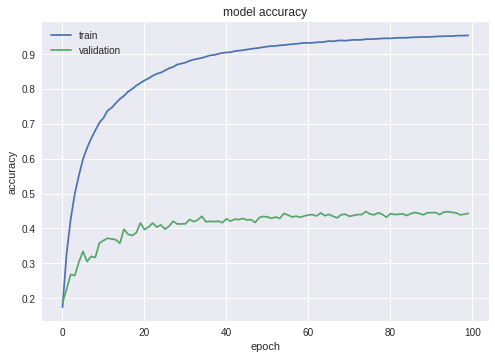

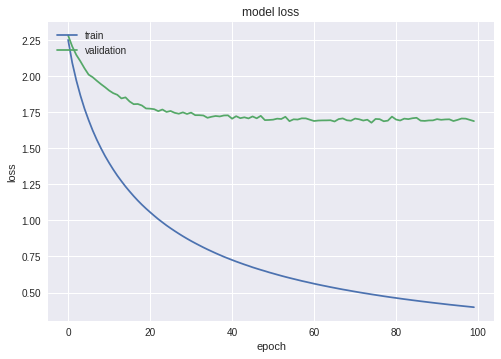

In [62]:
# Score model on train and validation sets.
# Create a dataframe to stroe the results from the training
# Plot training results
train_score = model.evaluate(X_train, y_train, verbose=0)
print('train score: ', train_score)

valid_score = model.evaluate(X_valid, y_valid, verbose=0)
print('valid score: ', valid_score)

train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']



results_df = pd.DataFrame(
    {'train_loss': train_loss,
     'train_acc': train_acc,
     'val_loss': val_loss,
     'val_acc': val_acc
    })





# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [63]:
# Print results for inspection

#print(results_df)
print(results_df[:10])
print(results_df[90:100])

   train_acc  train_loss   val_acc  val_loss
0   0.174113    2.253651  0.186413  2.284617
1   0.327686    2.095269  0.225352  2.208284
2   0.426587    1.972452  0.268020  2.149292
3   0.499850    1.867596  0.264706  2.104873
4   0.551674    1.776001  0.304060  2.056063
5   0.598851    1.697019  0.334300  2.012495
6   0.631134    1.624632  0.305302  1.994341
7   0.658071    1.560412  0.319801  1.969785
8   0.681259    1.502186  0.316901  1.946634
9   0.703548    1.448345  0.358326  1.925335
    train_acc  train_loss   val_acc  val_loss
90   0.949975    0.425712  0.445319  1.703481
91   0.950575    0.422565  0.445733  1.698806
92   0.951324    0.419180  0.439934  1.701259
93   0.951424    0.415907  0.446976  1.702203
94   0.951974    0.412929  0.448219  1.690321
95   0.951774    0.409831  0.446147  1.698230
96   0.952874    0.406890  0.444905  1.707753
97   0.953273    0.403912  0.439105  1.706745
98   0.953323    0.401035  0.440762  1.698313
99   0.953873    0.397988  0.443248  1.689719

In [0]:
# Name the model type to id weights and results
Model_type =  "LR"

In [65]:
# Save weights if model is acceptable

# serialize weights to HDF5
weights_filename = 'drive/Colab_Notebooks/Models/' + Model_type + "_" + train_data_filename + '_weights.h5'
print(str(weights_filename))
model.save_weights(weights_filename)

#model.save_weights(str(train_data_filename +".h5"))
#print("Saved model to disk")

drive/Colab_Notebooks/Models/LR_p075_p014_p045_1_96_128_weights.h5


In [66]:
# Save the training results file
results_filename = 'drive/Colab_Notebooks/Results/' + Model_type + "_" + train_data_filename + '_results.csv'
print(results_filename)
results_df.to_csv(results_filename, sep=',')

drive/Colab_Notebooks/Results/LR_p075_p014_p045_1_96_128_results.csv


In [0]:
from skimage.transform import rotate
def show_image(image):
    img = image.squeeze()
    plt.axis("off")
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(np.fliplr(rotate(img, 270)), cmap='gray', interpolation='nearest')  
    # Manipulation to display image in the correct orientation!
    plt.show() 
    #print image.shape
    #plt.imshow(image)

In [0]:
# function to convert probs to class
from skimage.transform import rotate

def predictions_results(prediction_probs):
    results = []
    for pred in prediction_probs:
        idx = np.argmax(pred)
        result = np.zeros(len(pred))
        result[idx] = 1
        results.append(result)
    return results


In [68]:
# predict on train set just to verify accuracy
train_predict_probs = model.predict(X_train, batch_size = batch_size, verbose = 1)

# convert prediction probabilities to class array for train set
y_train_predicted= predictions_results(train_predict_probs)


# convert the true and predicted array into classes

# For train data 

train_true_classes = np.argmax(y_train,  axis=1)
train_pred_classes = np.argmax(y_train_predicted,  axis=1)


20010/20010 [==============================] - 1s 42us/step


In [69]:
# Verify predictions for validation set
# collect predictions on valid set
# Store probs in a dataframe and csv for later use
valid_prediction_probs = model.predict(X_valid, batch_size = batch_size, verbose = 1)
print(valid_prediction_probs[1])

valid_probs_df= pd.DataFrame(valid_prediction_probs)
print(valid_probs_df[1:5])
valid_probs_filename = 'drive/Colab_Notebooks/Results/' + Model_type + "_" + train_data_filename + '_valid_probs.csv'
valid_probs_df.to_csv(valid_probs_filename, sep=',')


# convert prediction probabilities to class array for validation set
y_valid_predicted= predictions_results(valid_prediction_probs)
#print(y_valid_predicted[1])


# convert the true and predicted array into classes
# for validation set

valid_true_classes = np.argmax(y_valid,  axis=1)
valid_pred_classes = np.argmax(y_valid_predicted,  axis=1)


2414/2414 [==============================] - 0s 43us/step
[0.09 0.   0.01 0.19 0.39 0.16 0.   0.   0.06 0.09]
          0         1         2         3         4         5         6  \
1  0.093560  0.000541  0.011601  0.187810  0.388643  0.162876  0.002802   
2  0.096231  0.000636  0.011322  0.175867  0.370472  0.174473  0.002799   
3  0.078855  0.000454  0.012345  0.125558  0.158744  0.285247  0.002063   
4  0.087149  0.000523  0.008541  0.147269  0.532494  0.128975  0.003544   

          7         8         9  
1  0.002886  0.060028  0.089253  
2  0.003421  0.064505  0.100274  
3  0.003212  0.056964  0.276557  
4  0.001872  0.044839  0.044793  


In [70]:
# Add the validation predictions to valid_driver_list
# Add the true classes for now to ensure that the order of valid_driver_list and predictions is same.
#valid_df= pd.DataFrame()
valid_df['true'] = valid_true_classes
valid_df['pred'] = valid_pred_classes
valid_filename = 'drive/Colab_Notebooks/Results/' + Model_type + "_" + train_data_filename + '_valid.csv'
print(valid_filename)
print(valid_df.head(n=5))
valid_df.to_csv(valid_filename, sep=',')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


drive/Colab_Notebooks/Results/LR_p075_p014_p045_1_96_128_valid.csv
     subject classname             img  true  pred
1548    p014        c0   img_72495.jpg     0     4
1549    p014        c0   img_62101.jpg     0     4
1550    p014        c0   img_34774.jpg     0     4
1551    p014        c0  img_100312.jpg     0     5
1552    p014        c0   img_12279.jpg     0     4


Confusion matrix, without normalization
[[1991   33   13    6    9    4   14    3    9   15]
 [  23 1873   29    3    3    3   29    6    5    3]
 [  34   21 1937    9    2    0   12    5    4    4]
 [  28    8    6 1983   21    4    1    1    0    4]
 [  24   10    8   12 1952    1   12    2    4    8]
 [  22    1    9    6   10 1960    8    1    0    1]
 [  12    9   16    1   10    2 1947    8    9    5]
 [   8    5    9    1    8    1   11 1674   28    5]
 [  30   16   26   23   27    0   13   20 1485   28]
 [  33    6    3   15   11    9    7    8   39 1700]]
Normalized confusion matrix
[[9.49e-01 1.57e-02 6.20e-03 2.86e-03 4.29e-03 1.91e-03 6.68e-03 1.43e-03
  4.29e-03 7.15e-03]
 [1.16e-02 9.47e-01 1.47e-02 1.52e-03 1.52e-03 1.52e-03 1.47e-02 3.03e-03
  2.53e-03 1.52e-03]
 [1.68e-02 1.04e-02 9.55e-01 4.44e-03 9.86e-04 0.00e+00 5.92e-03 2.47e-03
  1.97e-03 1.97e-03]
 [1.36e-02 3.89e-03 2.92e-03 9.64e-01 1.02e-02 1.95e-03 4.86e-04 4.86e-04
  0.00e+00 1.95e-03]
 [1.18e-02 4.92e-03 3

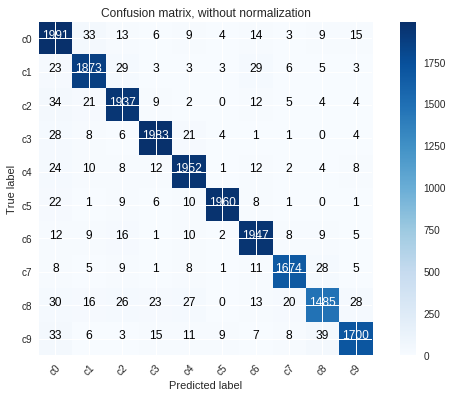

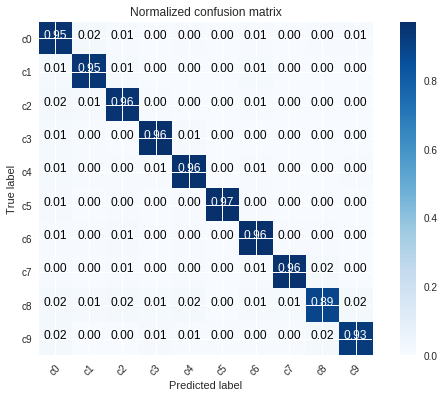

Confusion matrix, without normalization
[[245   7   1   0  51   0   1  62   3  22]
 [  2 164  20   0   2   0   5  58  39   0]
 [  0   0  61   0   4   0  60 156   8   0]
 [  0  37   0   5  14   0   0 162   0  72]
 [  0  11   0   2 136   0   0 113   7  24]
 [  0   1  58   0   0  85   0  58  90   2]
 [  0   3   0   0  22   2 122 150   7   0]
 [  0   0  39   0   0   0   0 193   2  18]
 [  1   7  43   0   0   1  49 127  11   4]
 [ 43   0   0   2  24   0   0 150  16  63]]
Normalized confusion matrix
[[0.62 0.02 0.   0.   0.13 0.   0.   0.16 0.01 0.06]
 [0.01 0.57 0.07 0.   0.01 0.   0.02 0.2  0.13 0.  ]
 [0.   0.   0.21 0.   0.01 0.   0.21 0.54 0.03 0.  ]
 [0.   0.13 0.   0.02 0.05 0.   0.   0.56 0.   0.25]
 [0.   0.04 0.   0.01 0.46 0.   0.   0.39 0.02 0.08]
 [0.   0.   0.2  0.   0.   0.29 0.   0.2  0.31 0.01]
 [0.   0.01 0.   0.   0.07 0.01 0.4  0.49 0.02 0.  ]
 [0.   0.   0.15 0.   0.   0.   0.   0.77 0.01 0.07]
 [0.   0.03 0.18 0.   0.   0.   0.2  0.52 0.05 0.02]
 [0.14 0.   0.   0.01 0.

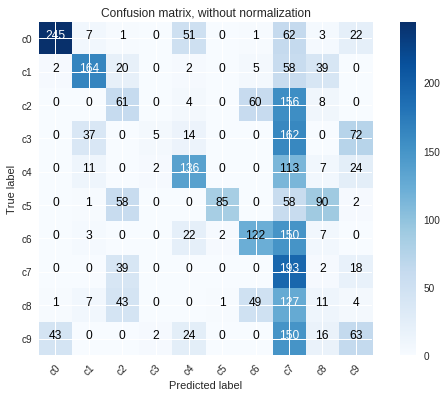

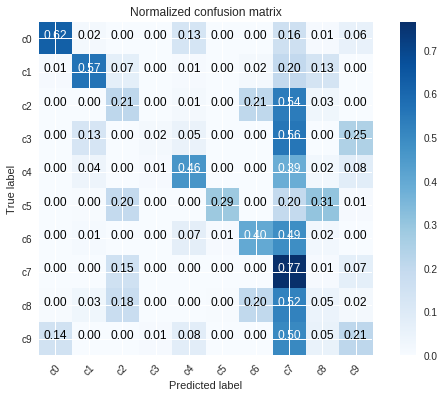

In [54]:
# Results visualization

# Confusion Matrix

class_names = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
class_names2 = ['c0', 'c1']


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
    
# Train data
cnf_matrix = confusion_matrix(train_true_classes, train_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


# Valid data

cnf_matrix = confusion_matrix(valid_true_classes, valid_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

###############################################################################

In [79]:
# Metrics

from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(valid_true_classes, valid_pred_classes, average='weighted')


from sklearn.metrics import classification_report
print(classification_report(valid_true_classes, valid_pred_classes, target_names=class_names))


             precision    recall  f1-score   support

         c0       0.96      0.32      0.48       315
         c1       0.59      0.39      0.47       301
         c2       0.50      0.40      0.45       321
         c3       0.40      0.66      0.50       299
         c4       0.46      0.67      0.55       286
         c5       1.00      0.45      0.62       293
         c6       0.27      0.49      0.35       295
         c7       0.49      0.65      0.56       286
         c8       0.66      0.63      0.65       272
         c9       0.46      0.29      0.36       295

avg / total       0.58      0.49      0.49      2963



correct_classfully validated 2454 / 2947 = 83.27112317611129%
Sample of images validated correctly:
***************
Rendering image 1622


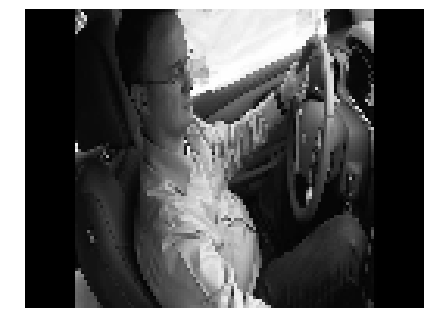

Classified correctly as c5: operating the radio

***************
Rendering image 1941


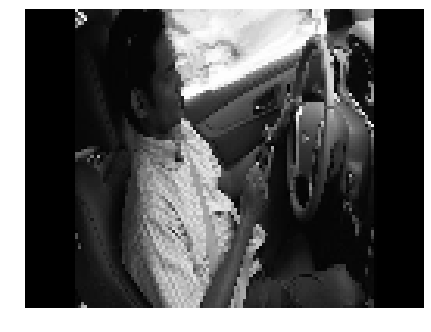

Classified correctly as c1: texting - right

***************
Rendering image 331


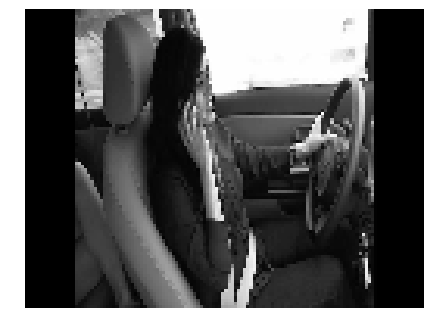

Classified correctly as c2: talking on the phone - right

***************
Rendering image 1321


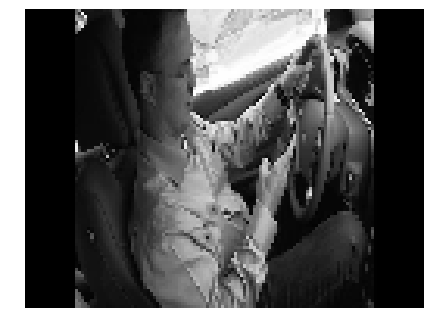

Classified correctly as c1: texting - right

***************
Rendering image 1641


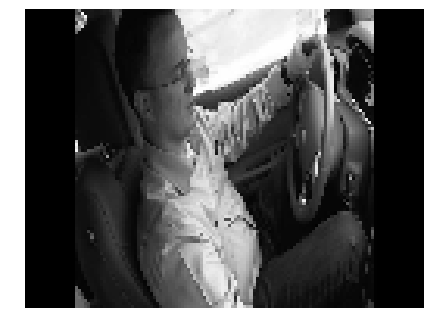

Classified correctly as c5: operating the radio

Sample of images validated incorrectly:
***************
Rendering image 156


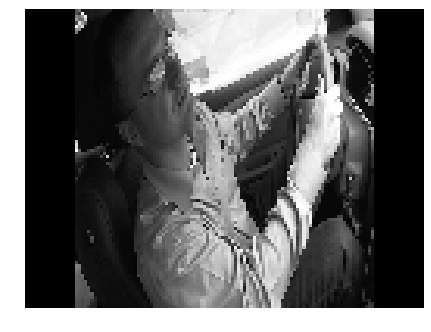

Classified incorrectly as c0: safe driving

***************
Rendering image 315


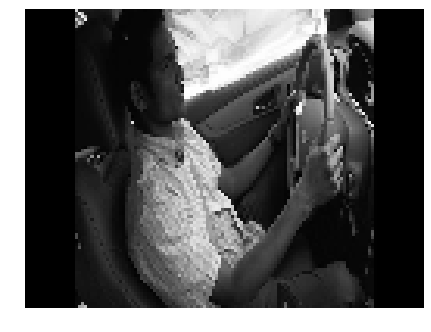

Classified incorrectly as c5: operating the radio

***************
Rendering image 16


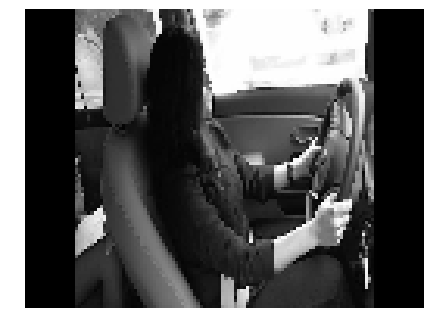

Classified incorrectly as c3: texting - left

***************
Rendering image 93


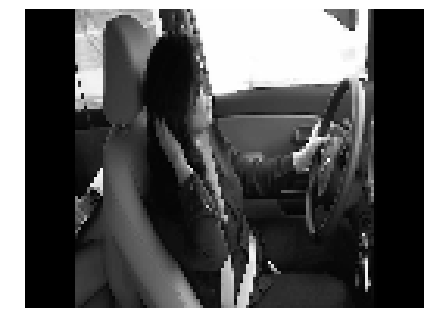

Classified incorrectly as c2: talking on the phone - right

***************
Rendering image 36


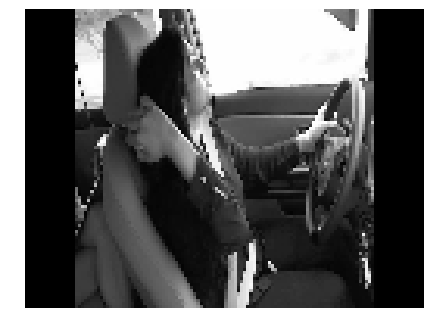

Classified incorrectly as c9: talking to passenger



In [0]:
# compare predicts with actual and count correct and incorrect classificaitons
correct_class = []
wrong_class = []
c = 0

for yc, yp in zip(valid_true_classes, valid_pred_classes):
    if yc == yp:
        #print "correct_class: Class {}, {} predicted".format(np.argmax(yclass), np.argmax(ypredict))
        correct_class.append([c, yp])
    else:
        #print "wrong_class!: Class {}, {} predicted".format(np.argmax(yclass), np.argmax(ypredict))
        wrong_class.append([c, yp])
    c += 1
    
print("correct_classfully validated {} / {} = {}%".format(len(correct_class), c, (float(len(correct_class))/float(c))*100))
#print "correct_class: {}".format(correct_class)
#print "wrong_class: {}".format(wrong_class)

# Create labels to assign to predictions and plot examples
# labels for org data (use for full data or sub1)
labels_org = [  'c0: safe driving',
            'c1: texting - right',
            'c2: talking on the phone - right',
            'c3: texting - left',
            'c4: talking on the phone - left',
            'c5: operating the radio',
            'c6: drinking',
            'c7: reaching behind',
            'c8: hair and makeup',
            'c9: talking to passenger']

# labels for two category sub2 data
labels_sub2 = [  'c0: safe driving',
            'c1: distracted driving']

# set correct labels
labels=labels_org

    
#print correct_class examples

print("Sample of images validated correctly:")
for s in np.random.choice(len(correct_class), 5, replace = False):
    print("***************\nRendering image {}".format(s))
    image = x_valid[correct_class[s][0]]
    show_image(image)
    print("Classified correctly as {}\n".format(labels[np.argmax(y_valid_predicted[correct_class[s][0]])]))
    
    
# print wrong classification examples    
print("Sample of images validated incorrectly:")
for s in np.random.choice(len(wrong_class), 5, replace = False):
    print("***************\nRendering image {}".format(s))
    image = x_valid[wrong_class[s][0]]
    show_image(image)
    print("Classified incorrectly as {}\n".format(labels[np.argmax(y_valid_predicted[wrong_class[s][0]])]))
    

